Trusted
Jupyter Server: local
Python 3: Idle





row_num: a number uniquely identifying each row.

• locale: the platform of the session.

• day_of_week: Mon-Fri, the day of the week of the session.

• hour_of_day: 00-23, the hour of the day of the session.

• agent_id: the device used for the session.

• entry_page: describes the landing page of the session.

• path_id_set: shows all the locations that were visited during the session.

• traffic_type: indicates the channel the user cane through eg. search engine, email, ...

• session_duration: the duration in seconds of the session.

• hits: the number of interactions with the trivago page during the session.

Task: Note that the column “hits” has missing values. Use this data to build a model that predicts the number of hits per session, depending on the given parameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy.random as nr
import scipy.stats as ss
import math
import functions as fn


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Data cleaning and basic statistics

In [2]:
df_original = pd.read_csv('MLDataScientistCaseStudyData2020.csv', header = None )
df_original.columns = ["row_num","locale","day_of_week","hour_of_day","agent_id","entry_page","path_id","traffic_type","session_duration","hits"]
df_original.head()

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id,traffic_type,session_duration,hits
0,1,L1,Saturday,23,1,2100,34308;0;183,1,617,\N
1,2,L3,Sunday,8,9,2113,32131;0,2,0,\N
2,3,L3,Saturday,14,9,2100,34330;0,6,17,\N
3,4,L2,Saturday,14,8,2116,89172;0,3,3,11
4,5,L5,Friday,9,2,2100,31777;0,1,610,67


Checking if there are wrong cells

In [3]:
(df_original.astype(np.object) == '?').any()

row_num             False
locale              False
day_of_week         False
hour_of_day         False
agent_id            False
entry_page          False
path_id             False
traffic_type        False
session_duration    False
hits                False
dtype: bool

In [4]:
(df_original.astype(np.object) == '\\N').any()

row_num             False
locale              False
day_of_week         False
hour_of_day         False
agent_id            False
entry_page          False
path_id             False
traffic_type        False
session_duration     True
hits                 True
dtype: bool

There are some rows without "Session_duration" and "hits". For the former I will check how many rows have missing values. The latter are the ones that I need to predict.

In [5]:
indexes = df_original['session_duration'] == '\\N'
df_original.dtypes

row_num              int64
locale              object
day_of_week         object
hour_of_day          int64
agent_id             int64
entry_page           int64
path_id             object
traffic_type         int64
session_duration    object
hits                object
dtype: object

Imputing the mean to the four missing values in the 'session_duration'

In [6]:
df_original['session_duration'] = df_original['session_duration'].replace('\\N', np.nan)
df_original['session_duration'] = df_original['session_duration'].astype(float)
mean = df_original['session_duration'].mean(skipna=True)
df_original['session_duration'].fillna(value=mean, inplace = True)
df_original['session_duration'] = df_original['session_duration'].astype(int)

In [7]:
df_original[indexes]

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id,traffic_type,session_duration,hits
96866,96867,L3,Friday,2,8,8101,35021;0,1,600,2
201828,201829,L3,Wednesday,0,1,8101,0;87192,1,600,\N
356451,356452,L1,Sunday,22,8,8101,0;102548,1,600,2
699208,699209,L3,Monday,0,1,8101,0;35094,1,600,\N


# Working on the test data

**will redefine my dataset here**,
as I will perform all the transformations and simplifications to all the features

In [8]:
df_complete = df_original

In [9]:
df_complete['n_ids'] = df_complete['path_id'].apply(lambda x:fn.path_counter(x))
df_complete.dtypes

row_num              int64
locale              object
day_of_week         object
hour_of_day          int64
agent_id             int64
entry_page           int64
path_id             object
traffic_type         int64
session_duration     int64
hits                object
n_ids                int64
dtype: object

In [10]:
fn.frequency_table(df_complete, ["n_ids"])


For column n_ids
2     650389
1     153735
3      90536
4      21185
0      20410
5       6901
6       2858
7       1305
8        728
9        391
10       243
11       152
12       107
13        62
14        57
15        32
16        25
17        17
18        14
20         9
19         5
21         4
22         4
26         3
28         3
30         3
31         3
23         2
24         2
39         2
42         1
36         1
38         1
27         1
35         1
25         1
67         1
Name: n_ids, dtype: int64
There are 37 unique values


In [11]:
df_complete['n_ids'].describe()

count    949194.000000
mean          1.991834
std           0.858485
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          67.000000
Name: n_ids, dtype: float64

## Categorical variables


## Locale

<AxesSubplot:xlabel='locale', ylabel='count'>

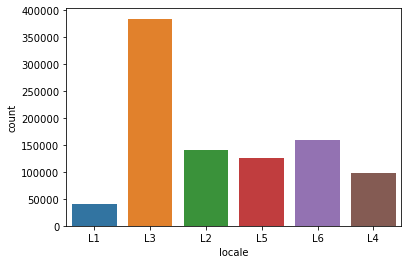

In [12]:
sns.countplot(x="locale", data=df_complete)

# Traffic type

<AxesSubplot:xlabel='traffic_type', ylabel='count'>

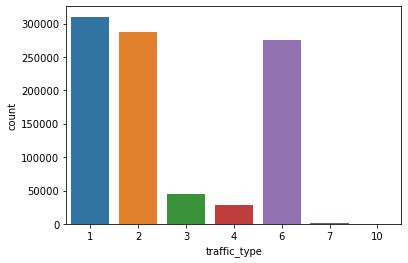

In [13]:
sns.countplot(x="traffic_type", data=df_complete)


## *Assumption*
With the results above (see countplot), it seems that is a good idea to agreggate some of the traffic types. I will use the function group_cat to aggregate categories with less than X% of the total number of hits. 

<AxesSubplot:xlabel='traffic_type_aggr', ylabel='count'>

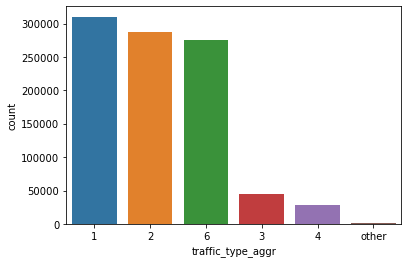

In [14]:
group, frequency = fn.group_cat(df_complete, 'traffic_type', 0.01)
df_complete['traffic_type_aggr'] = df_complete['traffic_type'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="traffic_type_aggr", data=df_complete)

## Agent Id

<AxesSubplot:xlabel='agent_id', ylabel='count'>

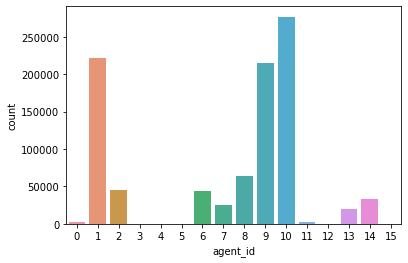

In [15]:
sns.countplot(x="agent_id", data=df_complete)

<AxesSubplot:xlabel='agent_aggr', ylabel='count'>

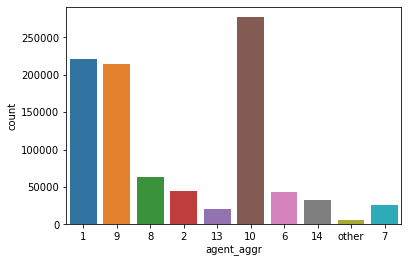

In [16]:
group, frequency = fn.group_cat(df_complete, 'agent_id', 0.003)
df_complete['agent_aggr'] = df_complete['agent_id'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="agent_aggr", data=df_complete)

## Entry Page

<AxesSubplot:xlabel='entry_page', ylabel='count'>

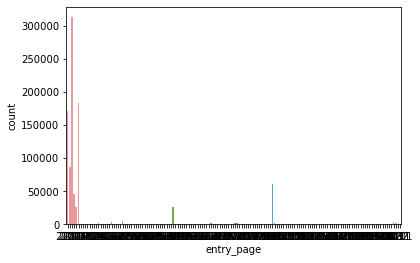

In [17]:
sns.countplot(x="entry_page", data=df_complete)

<AxesSubplot:xlabel='entry_aggr', ylabel='count'>

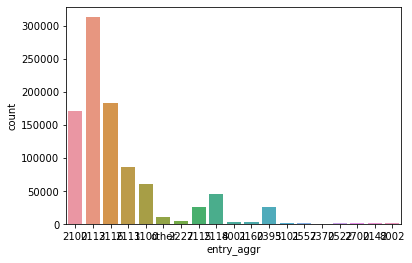

In [18]:
group, frequency = fn.group_cat(df_complete, 'entry_page', 0.001)
df_complete['entry_aggr'] = df_complete['entry_page'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="entry_aggr", data=df_complete)

## n_ids


<AxesSubplot:xlabel='n_ids', ylabel='count'>

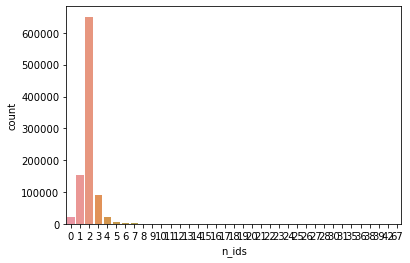

In [19]:
sns.countplot(x="n_ids", data=df_complete)

<AxesSubplot:xlabel='n_ids_aggr', ylabel='count'>

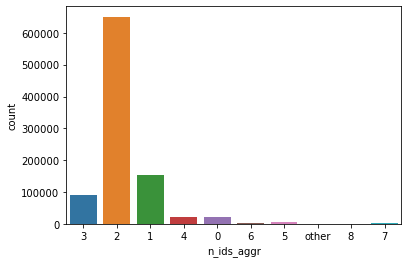

In [20]:
group, frequency = fn.group_cat(df_complete, 'n_ids', 0.0005)
df_complete['n_ids_aggr'] = df_complete['n_ids'].apply(lambda x:fn.cat_aggregation(x,group))
sns.countplot(x="n_ids_aggr", data=df_complete)

# Transforming numeric variables


## Session duration


I will need to transformate this variable in order to make it look more like a normal distribution. I can apply a logarithmic transformation. As there are some values with 0 seconds, actually most of them, I will apply log(x+1)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


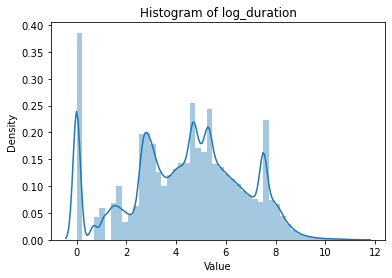

In [21]:
df_complete[['log_duration']] = df_complete[['session_duration']].applymap(np.log1p)
fn.hist_plot(df_complete, ['log_duration'])

## Hour of the day

Turning into a cyclical variable

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


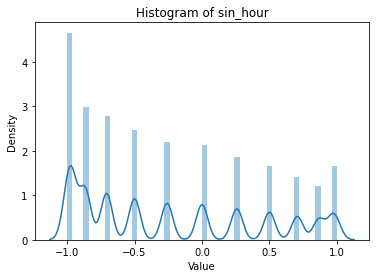

In [22]:
df_complete['sin_hour'] = np.sin(2*np.pi*df_complete['hour_of_day']/24)
df_complete['cos_hour'] = np.cos(2*np.pi*df_complete['hour_of_day']/24)
fn.hist_plot(df_complete, ['sin_hour'])

## Day of the week
I will convert the days into integers with the following dictionary. Later, I will make them cyclical variables as well. 

In [23]:
dict_day =  {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5,'Sunday':6}
df_complete['day_of_week_num'] = [dict_day[x] for x in df_complete['day_of_week']]

In [24]:
df_complete['sin_day'] = np.sin(2*np.pi*df_complete['day_of_week_num']/7)
df_complete['cos_day'] = np.cos(2*np.pi*df_complete['day_of_week_num']/7)


# Preparing the model matrix

## Creating dummy variables from categorical features

In [25]:
categorical_columns = ['agent_aggr','locale', 'entry_aggr', 'traffic_type_aggr','n_ids_aggr']

for i,col in enumerate(categorical_columns):
    print(col)
    print("These are the dummy variables %s"%(df_complete[col].unique()))
    temp = fn.encode_string(df_complete[col])
    if i == 0:
        features = temp
    else:
        features = np.concatenate([features, temp], axis = 1)
rows ,n_categorical = features.shape
print("\nAfter encoding there are %s categorical variables"%n_categorical)
print(features.shape)

agent_aggr
These are the dummy variables ['1' '9' '8' '2' '13' '10' '6' '14' 'other' '7']
locale
These are the dummy variables ['L1' 'L3' 'L2' 'L5' 'L6' 'L4']
entry_aggr
These are the dummy variables ['2100' '2113' '2116' '2111' '3100' 'other' '2227' '2115' '2114' '8001'
 '2160' '2395' '3101' '2557' '2370' '2522' '2700' '2142' '8002']
traffic_type_aggr
These are the dummy variables ['1' '2' '6' '3' '4' 'other']
n_ids_aggr
These are the dummy variables ['3' '2' '1' '4' '0' '6' '5' 'other' '8' '7']

After encoding there are 51 categorical variables
(949194, 51)


In [26]:
features = np.concatenate([features, np.array(df_complete[['log_duration', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day']])], axis = 1)
np.shape(features)

(949194, 56)

# Splitting the datasets 
between training set and test set (with missing hits)


In [27]:
indexes_test = df_complete['hits'] == '\\N'
indexes_train = df_complete['hits']!= '\\N'


features_test = features[df_complete.index[indexes_test]]
features_train = features[df_complete.index[indexes_train]]

df_test = df_complete.loc[indexes_test] 
df_train = df_complete.loc[indexes_train]


# Now I can cast the hits into int
df_train['hits'] = df_train['hits'].astype(int)


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Hits(Label)

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


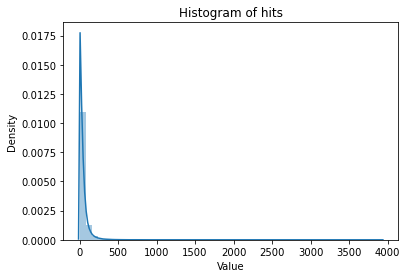

In [28]:
fn.hist_plot(df_train, ['hits'])


The 'hits' distribution is also right-skewed. Therefore, I will apply a logarithmic transformation

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


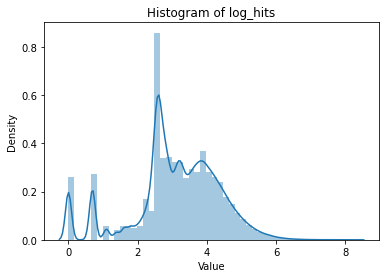

In [29]:
df_train[['log_hits']] = df_train[['hits']].applymap(math.log)
fn.hist_plot(df_train, ['log_hits'])

## Sanity Check

Splitting the train set in "train_train" and "train_test" 

In [30]:
nr.seed(9988)
labels = np.array(df_train['log_hits'])
indx = range(features_train.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train_train = features_train[indx[0],:]
y_train_train = np.ravel(labels[indx[0]])
x_train_test = features_train[indx[1],:]
y_train_test = np.ravel(labels[indx[1]])

labels = np.array(df_train['log_hits'])

x_train = features
y_train = np.ravel(labels)

x_test = features_test

## Rescale numeric features
To prevent features from having an influence on the model training because then have a larger range of numeric variables. I will rescale the numeric features. Also, rescaling will help to asses the importance of the variables from the coefficients

In [31]:
scaler = preprocessing.StandardScaler().fit(x_train_train[:,n_categorical:])
x_train_train[:,n_categorical:] = scaler.transform(x_train_train[:,n_categorical:])
x_train_test[:,n_categorical:] = scaler.transform(x_train_test[:,n_categorical:])

features_test[:,n_categorical:] = scaler.transform(features_test[:,n_categorical:])

print(x_train_train.shape)
x_train_train[:1,:]

(483157, 56)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.72777937, -0.39357919,  1.27741011, -1.17538942,
         0.82264559]])

# Neural Network
I will build a NN for the same dataset to compare the results. I expect that the results improve and that it can predict some of the substructures and rare events that the linear regression is not able to capture.

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

As a first approximation, I will use one hidden layer of size 100. With the amount of data ~0.6 M. A better topology can be used and optimised later. For now, just comparing with the linear regression

In [33]:
regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes = (100))

In [34]:
regr.fit(x_train_train, y_train_train)

MLPRegressor(hidden_layer_sizes=100, max_iter=500, random_state=1)

In [35]:
y_score = regr.predict(x_train_test)

In [36]:
len(y_score)

120790

In [37]:
len(y_train_test)

120790

In [38]:
fn.print_metrics(y_train_test, y_score) 

Mean Square Error      = 0.22221391648601083
Root Mean Square Error = 0.47139571114511725
Mean Absolute Error    = 0.3200654534534754
Median Absolute Error  = 0.20703840506681315
R^2                    = 0.857739559542739


/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


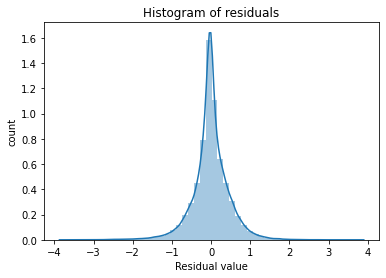

In [39]:
fn.hist_resids(y_train_test, y_score) 

The RMSE is lower than with the linear regression and the histogram of residuals is more symmetrical, improving a bit the results.

# Predictions for the test

In [40]:
y_predict = regr.predict(features_test)

In [41]:
y_predict_untransform = np.exp(y_predict)

In [42]:
df_test['hits'] = y_predict_untransform

/Users/simon/opt/anaconda3/envs/simon3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Saving the output

In [43]:
df_test[['row_num','hits']].to_csv('trivago_results.csv', index = False, header = False)

In [44]:
df_test.head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id,traffic_type,session_duration,hits,...,traffic_type_aggr,agent_aggr,entry_aggr,n_ids_aggr,log_duration,sin_hour,cos_hour,day_of_week_num,sin_day,cos_day
0,1,L1,Saturday,23,1,2100,34308;0;183,1,617,101.868109,...,1,1,2100,3,6.426488,-0.258819,9.659258e-01,5,-0.974928,-0.222521
1,2,L3,Sunday,8,9,2113,32131;0,2,0,2.226829,...,2,9,2113,2,0.000000,0.866025,-5.000000e-01,6,-0.781831,0.623490
2,3,L3,Saturday,14,9,2100,34330;0,6,17,15.591551,...,6,9,2100,2,2.890372,-0.500000,-8.660254e-01,5,-0.974928,-0.222521
9,10,L4,Tuesday,18,1,2100,79447;0,1,295,61.529397,...,1,1,2100,2,5.690359,-1.000000,-1.836970e-16,1,0.781831,0.623490
13,14,L2,Friday,21,1,2100,0,1,58,16.697100,...,1,1,2100,1,4.077537,-0.707107,7.071068e-01,4,-0.433884,-0.900969
14,15,L2,Sunday,10,8,2116,4329,3,0,1.011605,...,3,8,2116,1,0.000000,0.500000,-8.660254e-01,6,-0.781831,0.623490
16,17,L6,Monday,14,10,2100,39130;442656;0,1,133,67.041798,...,1,10,2100,3,4.897840,-0.500000,-8.660254e-01,0,0.000000,1.000000
17,18,L6,Thursday,18,6,2113,93078;0,6,269,16.871795,...,6,6,2113,2,5.598422,-1.000000,-1.836970e-16,3,0.433884,-0.900969
19,20,L3,Friday,2,14,2113,35087;0,6,58,15.323716,...,6,14,2113,2,4.077537,0.500000,8.660254e-01,4,-0.433884,-0.900969
23,24,L2,Monday,5,9,2116,31694;0,4,17,17.552515,...,4,9,2116,2,2.890372,0.965926,2.588190e-01,0,0.000000,1.000000
